In [16]:
import numpy as np

def strip_first_col(fname, delimiter=None):
    with open(fname, 'r') as fin:
        for line in fin:
            try:
               yield line.split(delimiter, 1)[1]
            except IndexError:
               continue

In [17]:
filename = 'jund_all_kmer_counts.tsv'
np.random.seed(0)
ncols = 0
ids = []
with open(filename) as f:
    ncols = len(f.readline().split('\t'))
    for line in f:
        ids.append(line.split("\t",1)[0])
ids = np.array(ids)

In [18]:
X = np.loadtxt(strip_first_col(filename),skiprows=1)

In [21]:
numPos = 6979
numNeg = 6979
numTotal = numPos + numNeg
pos_examples = X[:numPos][:]
neg_examples = X[numPos:][:]
pos_ids = ids[:numPos]
neg_ids = ids[numPos:]

posPermutation = np.random.permutation(numPos)
negPermutation = np.random.permutation(numNeg)

pos_ids = pos_ids[posPermutation]
neg_ids = neg_ids[negPermutation]
pos_examples = pos_examples[posPermutation][:]
neg_examples = neg_examples[negPermutation][:]

numPosTrain = numPos/2
numNegTrain = numNeg/2

numPosTest = numPos - numPosTrain
numNegTest = numNeg - numNegTrain

pos_train = pos_examples[:numPosTrain][:]
neg_train = neg_examples[:numNegTrain][:]
Xtrain = np.concatenate((pos_train, neg_train))

pos_test = pos_examples[numPosTrain:][:]
neg_test = neg_examples[numNegTrain:][:]
Xtest = np.concatenate((pos_test, neg_test))

Ytrain = np.concatenate((2*np.ones(numPosTrain, dtype=int), np.ones(numNegTrain, dtype=int)))
Ytest = np.concatenate((2*np.ones(numPosTest, dtype=int), np.ones(numNegTest, dtype=int)))

featureMins = np.min(Xtrain, axis=0)
featureMaxs = np.max(Xtrain, axis=0)

Xtrain = np.subtract(Xtrain, featureMins)
Xtrain = np.divide(Xtrain, featureMaxs - featureMins)

Xtest = np.subtract(Xtest, featureMins)
Xtest = np.divide(Xtest, featureMaxs - featureMins)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [23]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(Xtrain, Ytrain)
clf_probs = clf.predict_proba(Xtest)
pred = clf.predict(Xtest)
score = log_loss(Ytest, clf_probs)

In [24]:
fpr, tpr, thresholds = roc_curve(Ytest, clf_probs[:,1], pos_label=2)

In [25]:
auc(fpr, tpr)

0.79001855485587147

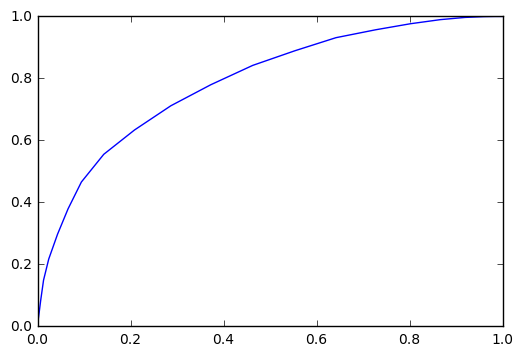

In [26]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [27]:
features = np.loadtxt('jund_all_kmer_vocab.txt', dtype=str)

In [28]:
feature_importance_order = np.argsort(clf.feature_importances_)[::-1]

features_sorted_by_importance = features[feature_importance_order]
feature_importances_sorted = clf.feature_importances_[feature_importance_order]

In [29]:
features_sorted_by_importance

array(['TGANTC', 'TNACTC', 'TGACTN', ..., 'CGAGAG', 'TCNGCG', 'CGTAGG'], 
      dtype='|S6')

In [30]:
print features_sorted_by_importance[0:50]
print feature_importances_sorted[0:50]

['TGANTC' 'TNACTC' 'TGACTN' 'ACTCAN' 'GACTCA' 'GTCANN' 'AGTCAT' 'NNGTCA'
 'NGTCAT' 'NACTCA' 'NTGACT' 'TGACTC' 'GTCATN' 'TGANNC' 'GNTGAC' 'TGACNC'
 'GACTCN' 'TGNGTC' 'ANTCAT' 'ACTCAT' 'NCGTCA' 'ACGNCA' 'ACGTCA' 'AGTNAT'
 'ATGNGT' 'TGACTA' 'GACTNN' 'GTCATA' 'TNTATT' 'CTCATN' 'GNCTCA' 'NACGTC'
 'ATTNNA' 'NNGTGA' 'AANTGA' 'GCGGNN' 'ATNNAA' 'NNGCGG' 'TGACNT' 'AAAANT'
 'ACTNNC' 'GACGNC' 'GTCATT' 'TNNCGG' 'ANGACT' 'NGACTC' 'TGAAAN' 'CAGCNG'
 'TCATTN' 'CAGNCT']
[ 0.02279464  0.00619942  0.00603215  0.00464458  0.0046389   0.00455345
  0.00402763  0.00401281  0.00357248  0.00345776  0.00320888  0.00313709
  0.00292862  0.00277828  0.00268473  0.00244937  0.00235918  0.00223751
  0.00219799  0.0021698   0.00208702  0.00197498  0.00192263  0.00188081
  0.00172687  0.00163993  0.00163029  0.00159899  0.0015637   0.00153665
  0.00150138  0.00148288  0.00147774  0.00145969  0.00143278  0.00140376
  0.00138466  0.00134602  0.00134076  0.00130939  0.00130925  0.00130221
  0.00130147  0.00129493  0.001

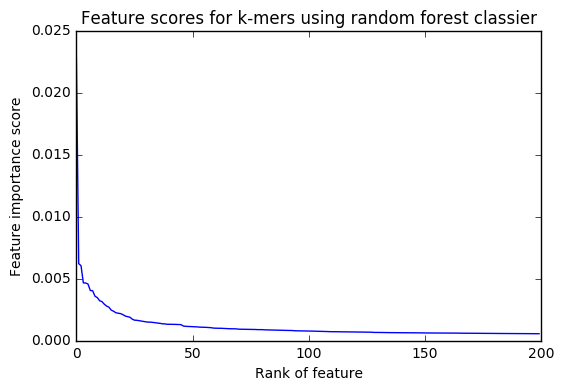

In [31]:
plt.plot(feature_importances_sorted[0:200])
plt.title("Feature scores for k-mers using random forest classier")
plt.ylabel("Feature importance score")
plt.xlabel("Rank of feature")
plt.show()

In [32]:
sum(pred==Ytest)*1.0/len(Ytest)

0.71275071633237819

In [33]:
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(Xtrain, Ytrain) 
pred = clf.predict(Xtest)

In [34]:
sum(pred==Ytest)*1.0/len(pred)

0.73137535816618915

In [35]:
predProb = clf.predict_proba(Xtest)

In [36]:
svm_fpr, svm_tpr, thresholds = roc_curve(Ytest, predProb[:,1], pos_label=2)

In [37]:
auc(svm_fpr, svm_tpr)

0.81250071838490645

In [38]:
np.savetxt('svm_roc.txt', np.stack((svm_fpr, svm_tpr)).T)

In [39]:
np.savetxt('rf_roc.txt', np.stack((fpr, tpr)).T)